In [1]:
#%pip install numpy tensorflow
#%pip install matplotlib

# 0. Importacion de Librerias

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Preparación de Datos (Preprocesamiento)

In [3]:
# Ruta base del dataset (ajustar a la ruta donde está ubicado el dataset_coco)
data_dir = "/Users/pipepatino/Desktop/Portafolio/Pruebas_Tecnicas/Yamaha_v1/CNN/dataset_coco"

In [4]:
# Definimos tamaño de imagen deseado (ejemplo: 224x224 píxeles)
IMG_SIZE = 224

In [5]:
def load_dataset_split(split="train"):
    """
    Carga las anotaciones COCO de la carpeta 'split' (train, valid o test) 
    y prepara listas de rutas de imagen, labels de clase y cajas (bbox).
    Retorna tres listas: image_paths, class_labels, bbox_labels.
    """
    json_path = os.path.join(data_dir, split, "_annotations.coco.json")
    with open(json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Crear diccionarios de ayuda
    images_info = {img["id"]: img for img in coco_data["images"]}
    # En COCO, las categorías incluyen un id 0 "objects" que no se usa directamente.
    # Las categorías de interés son id 1 ("placa_carro") y id 2 ("placa_moto").
    # Mapearemos 1->0 y 2->1 para tener labels de clase 0 o 1.
    
    image_paths = []
    class_labels = []
    bbox_labels = []
    
    for ann in coco_data["annotations"]:
        img_id = ann["image_id"]
        # Obtener info de la imagen correspondiente
        img_info = images_info.get(img_id)
        if img_info is None:
            continue  # seguridad: saltar si no hay info (no debería pasar)
        filename = img_info["file_name"]
        # Construir ruta completa del archivo de imagen
        img_path = os.path.join(data_dir, split, filename)
        
        # Obtener categoría de la placa: 1->placa_carro, 2->placa_moto
        cat_id = ann["category_id"]
        if cat_id not in [1, 2]:
            # Si la anotación no es de placa (por ejemplo, id 0 "objects"), la ignoramos
            continue
        # Re-etiquetar categoría: 0 para carro, 1 para moto
        class_label = 0 if cat_id == 1 else 1
        
        # Obtener caja delimitadora (COCO formato [x, y, width, height])
        x, y, w, h = ann["bbox"]
        img_w = img_info["width"]
        img_h = img_info["height"]
        # Normalizar coordenadas de la bbox en rango [0,1]
        x_norm = x / img_w
        y_norm = y / img_h
        w_norm = w / img_w
        h_norm = h / img_h
        
        # Almacenar resultados
        image_paths.append(img_path)
        class_labels.append(class_label)
        bbox_labels.append([x_norm, y_norm, w_norm, h_norm])
    
    # Convertir a numpy arrays para integrarlos con TensorFlow fácilmente
    class_labels = np.array(class_labels, dtype=np.int32)
    bbox_labels = np.array(bbox_labels, dtype=np.float32)
    return image_paths, class_labels, bbox_labels

In [6]:
# Cargar cada división de datos
train_paths, train_classes, train_bboxes = load_dataset_split("train")
val_paths, val_classes, val_bboxes = load_dataset_split("valid")
test_paths, test_classes, test_bboxes = load_dataset_split("test")

In [ ]:
print(f"Ejemplos en entrenamiento: {len(train_paths)}, validación: {len(val_paths)}, prueba: {len(test_paths)}")

# Verificar formato de un ejemplo
print("Ejemplo ruta:", train_paths[0])
print("Ejemplo clase (0=carro,1=moto):", train_classes[0])
print("Ejemplo bbox normalizada [x, y, w, h]:", train_bboxes[0])


Ejemplos en entrenamiento: 240, validación: 34, prueba: 17
Ejemplo ruta: /Users/pipepatino/Desktop/Portafolio/Pruebas_Tecnicas/Yamaha_v1/CNN/dataset_coco/train/4385047379_b3c4e3dea0_w_jpg.rf.f0d3c88e796f82bfb099892b559ebf77.jpg
Ejemplo clase (0=carro,1=moto): 0
Ejemplo bbox normalizada [x, y, w, h]: [0.0359375 0.5609375 0.8533328 0.3018547]


# 2. Conjunto de Datos en Tensores y Aumento de Datos (Data Augmentation)

In [8]:
# Función de preprocesamiento que será aplicada a cada imagen y sus etiquetas
def preprocess_image(img_path, class_label, bbox_label):
    # Leer y decodificar la imagen
    image_file = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image_file, channels=3)  # decodificar en 3 canales de color (RGB)
    # Redimensionar la imagen al tamaño deseado
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Convertir a float32 y escalar píxeles de 0-255 a 0-1
    image = tf.cast(image, tf.float32) / 255.0
    
    # Aumento de datos - aplicar solo en entrenamiento (controlaremos esto al crear el dataset)
    # Ejemplo: ajuste aleatorio de brillo y contraste
    image = tf.image.random_brightness(image, max_delta=0.2)   # variación de brillo
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # variación de contraste
    
    # Flip horizontal aleatorio
    # Generar un valor aleatorio 0-1
    do_flip = tf.random.uniform(shape=[]) > 0.5
    def flip_image():
        flipped_img = tf.image.flip_left_right(image)
        return flipped_img
    image = tf.cond(do_flip, flip_image, lambda: image)
    # Si se voltea la imagen, ajustar la bbox horizontalmente:
    if_flip = tf.cast(do_flip, tf.float32)
    # bbox_label = [x, y, w, h] normalizado
    x, y, w, h = tf.unstack(bbox_label)
    # Calcular x del lado derecho (x2) antes del flip para entender la operación: x2 = x + w
    x2 = x + w
    # Nueva coordenada x después del flip horizontal: 
    # Si la imagen se voltea, el nuevo x será (1 - x2), de lo contrario queda igual.
    new_x = if_flip * (1.0 - x2) + (1.0 - if_flip) * x
    # La anchura w permanece igual tras el flip, y y,h no cambian
    bbox_label = tf.stack([new_x, y, w, h])
    
    return image, (class_label, bbox_label)


In [ ]:
# Construir datasets de TensorFlow a partir de los arrays de rutas y labels
batch_size = 32

# Dataset de entrenamiento
ds_train = tf.data.Dataset.from_tensor_slices((train_paths, train_classes, train_bboxes))
# Mezclar aleatoriamente el conjunto de entrenamiento para evitar orden fijo
ds_train = ds_train.shuffle(buffer_size=len(train_paths), reshuffle_each_iteration=True)
# Aplicar preprocesamiento (map) y repetir indefinidamente
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Agrupar en lotes
ds_train = ds_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.223747..1.1600045].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10873218..0.7723853].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.059837747..1.1168358].


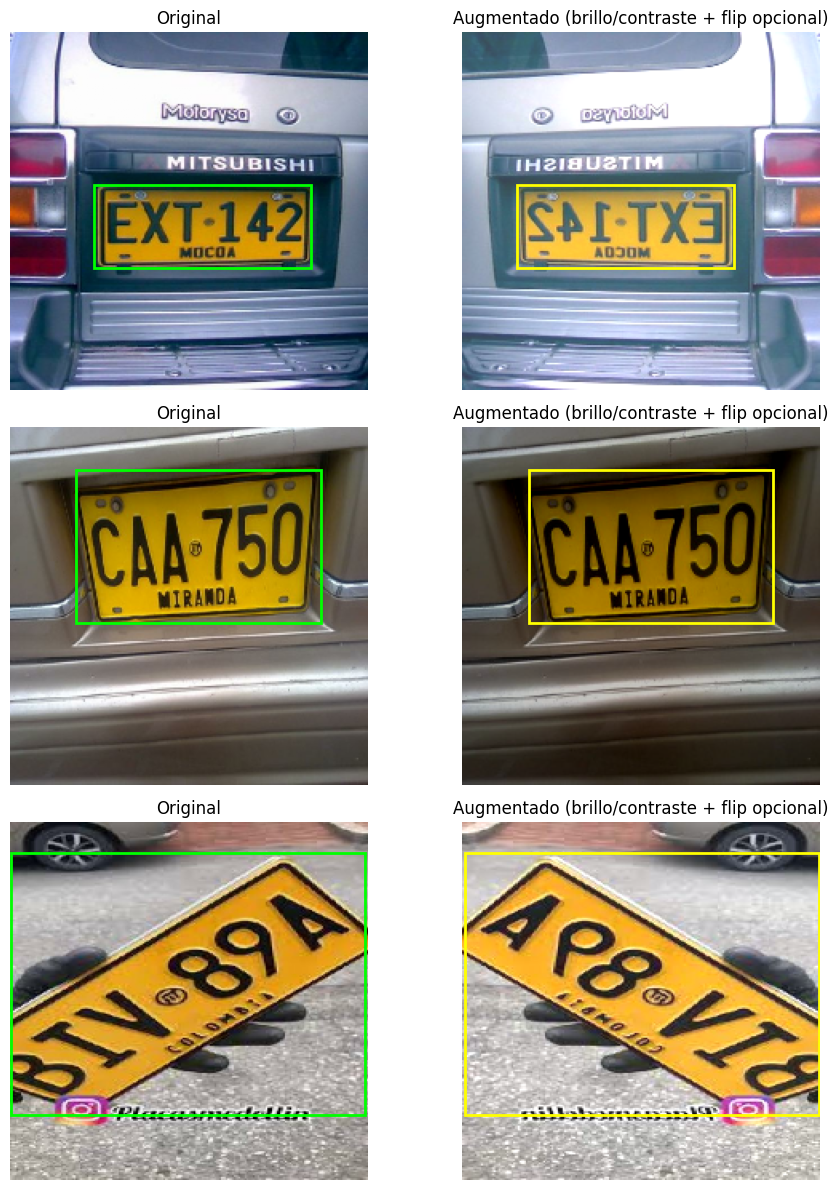

In [ ]:
# ===============================
# VISUALIZACIÓN DE DATA AUGMENTATION
# ===============================
# Este script permite:
# 1. Cargar imágenes y bounding boxes desde anotaciones en formato COCO.
# 2. Decodificar y redimensionar imágenes.
# 3. Aplicar técnicas de data augmentation (brillo, contraste, flip horizontal).
# 4. Ajustar las bounding boxes en caso de transformaciones.
# 5. Visualizar imágenes originales y augmentadas con sus cajas.

# ----------------------------------------
# Configuración
# ----------------------------------------

# Ruta base del dataset en formato COCO
DATA_DIR = Path("/Users/pipepatino/Desktop/Portafolio/Pruebas_Tecnicas/Yamaha_v1/CNN/dataset_coco")            
SPLIT = "train"                # División a cargar: "train", "valid" o "test"
IMG_SIZE = 224                 # Tamaño de redimensionamiento de imágenes
N_EXAMPLES = 3                 # Número de ejemplos a visualizar (original/augmentado)

# ----------------------------------------
# Cargar dataset COCO agrupado por imagen
# ----------------------------------------
def load_split_grouped(split: str):
    """
    Carga un split del dataset COCO y agrupa anotaciones por imagen.

    Args:
        split (str): división a cargar ("train", "valid" o "test").

    Returns:
        list[dict]: lista de diccionarios, cada uno con:
            - 'path': ruta de la imagen.
            - 'bboxes': lista de cajas normalizadas [x, y, w, h].
            - 'classes': lista de clases (0=placa_carro, 1=placa_moto).
    """
    jpath = DATA_DIR / split / "_annotations.coco.json"
    coco = json.loads(jpath.read_text())
    id2img = {im["id"]: im for im in coco["images"]}

    grouped = {}
    for ann in coco["annotations"]:
        cat = ann["category_id"]
        if cat not in (1, 2):  # solo consideramos placas
            continue
        img_info = id2img[ann["image_id"]]
        W, H = img_info["width"], img_info["height"]
        x, y, w, h = ann["bbox"]
        path = str(DATA_DIR / split / img_info["file_name"])

        key = img_info["id"]
        if key not in grouped:
            grouped[key] = {"path": path, "bboxes": [], "classes": []}
        grouped[key]["bboxes"].append([x/W, y/H, w/W, h/H])      # normalizar
        grouped[key]["classes"].append(0 if cat == 1 else 1)     # 0=carro,1=moto

    return list(grouped.values())

# ----------------------------------------
# Decodificar/redimensionar imagen
# ----------------------------------------
def decode_resize(path: str) -> tf.Tensor:
    """
    Decodifica una imagen y la redimensiona a IMG_SIZE x IMG_SIZE.

    Args:
        path (str): ruta de la imagen.

    Returns:
        tf.Tensor: imagen normalizada en [0,1].
    """
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return tf.cast(img, tf.float32) / 255.0

# ----------------------------------------
# Data augmentation
# ----------------------------------------
def augment_image_and_bboxes(img: tf.Tensor, bboxes: tf.Tensor):
    """
    Aplica data augmentation a una imagen y ajusta las bounding boxes.

    Transformaciones aplicadas:
      - Variaciones de brillo y contraste.
      - Flip horizontal con probabilidad 0.5.

    Args:
        img (tf.Tensor): imagen de entrada.
        bboxes (tf.Tensor): cajas normalizadas [x, y, w, h].

    Returns:
        (img_aug, bboxes_aug): imagen y cajas transformadas.
    """
    # Variaciones fotométricas
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)

    # Flip horizontal
    do_flip = tf.random.uniform(()) > 0.5
    img = tf.cond(do_flip, lambda: tf.image.flip_left_right(img), lambda: img)

    # Ajustar bboxes si hubo flip
    if bboxes.shape.rank == 1:  # por si viene una sola bbox
        bboxes = tf.expand_dims(bboxes, axis=0)

    x = bboxes[:, 0]
    y = bboxes[:, 1]
    w = bboxes[:, 2]
    h = bboxes[:, 3]
    x2 = x + w
    new_x = tf.where(do_flip, 1.0 - x2, x)
    new_bboxes = tf.stack([new_x, y, w, h], axis=1)
    return img, new_bboxes

# ----------------------------------------
# Función para dibujar bounding boxes
# ----------------------------------------
def draw_bboxes(ax, bboxes, color='r', linewidth=2):
    """
    Dibuja bounding boxes sobre un eje de Matplotlib.

    Args:
        ax: objeto matplotlib Axes.
        bboxes: lista/array de cajas normalizadas [x,y,w,h].
        color (str): color de las cajas.
        linewidth (int): grosor de línea.
    """
    for (x, y, w, h) in bboxes:
        x1 = int(x * IMG_SIZE)
        y1 = int(y * IMG_SIZE)
        w_px = int(w * IMG_SIZE)
        h_px = int(h * IMG_SIZE)
        rect = patches.Rectangle((x1, y1), w_px, h_px, 
                                 linewidth=linewidth, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

# ----------------------------------------
# Muestreo y visualización
# ----------------------------------------
items = load_split_grouped(SPLIT)
if len(items) == 0:
    raise RuntimeError(f"No se encontraron anotaciones en {DATA_DIR}/{SPLIT}")

# Seleccionar aleatoriamente ejemplos a mostrar
sampled = random.sample(items, k=min(N_EXAMPLES, len(items)))

# Crear figura con pares (original / augmentado)
fig, axes = plt.subplots(N_EXAMPLES, 2, figsize=(10, 4*N_EXAMPLES))
if N_EXAMPLES == 1:
    axes = np.array([axes])  # asegurar forma 2D

for r, item in enumerate(sampled):
    # ORIGINAL
    img_orig = decode_resize(item["path"])
    bboxes_orig = tf.constant(item["bboxes"], dtype=tf.float32)

    # AUGMENTADO
    img_aug, bboxes_aug = augment_image_and_bboxes(img_orig, bboxes_orig)

    # Convertir a numpy para mostrar
    img_o = img_orig.numpy()
    img_a = img_aug.numpy()
    bbs_o = bboxes_orig.numpy()
    bbs_a = bboxes_aug.numpy()

    # Columna izquierda: original
    axL = axes[r, 0]
    axL.imshow(img_o)
    draw_bboxes(axL, bbs_o, color='lime')
    axL.set_title("Original")
    axL.axis('off')

    # Columna derecha: augmentado
    axR = axes[r, 1]
    axR.imshow(img_a)
    draw_bboxes(axR, bbs_a, color='yellow')
    axR.set_title("Augmentado (brillo/contraste + flip opcional)")
    axR.axis('off')

plt.tight_layout()
plt.show()


In [11]:
# Dataset de validación (sin aumentos de datos, solo preprocesamiento básico)
ds_val = tf.data.Dataset.from_tensor_slices((val_paths, val_classes, val_bboxes))
ds_val = ds_val.map(lambda img, cls, bbox: (
    # Preprocesamiento básico sin augmentación:
    tf.cast(tf.image.resize(tf.io.decode_jpeg(tf.io.read_file(img), channels=3), (IMG_SIZE, IMG_SIZE)), tf.float32)/255.0,
    (cls, bbox)
), num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [12]:
# Dataset de prueba (similar a validación, sin aumentos)
ds_test = tf.data.Dataset.from_tensor_slices((test_paths, test_classes, test_bboxes))
ds_test = ds_test.map(lambda img, cls, bbox: (
    tf.cast(tf.image.resize(tf.io.decode_jpeg(tf.io.read_file(img), channels=3), (IMG_SIZE, IMG_SIZE)), tf.float32)/255.0,
    (cls, bbox)
), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 3. Construcción del Modelo CNN

En este bloque se define una **Red Neuronal Convolucional (CNN) de múltiples salidas** para la tarea de detección de placas vehiculares.
El modelo recibe como entrada imágenes de tamaño `224x224x3` y genera dos salidas:

1. **Clasificación** (softmax con 2 clases: `placa_carro` y `placa_moto`).
2. **Regresión de bounding box** (4 valores normalizados `[x, y, w, h]` que describen la posición de la placa en la imagen).


## Justificación de la arquitectura 

1. **Profundidad progresiva**

   * Se usan **4 bloques convolucionales** que incrementan el número de filtros (32 → 64 → 128 → 256).
   * Esto permite que las capas iniciales aprendan características simples (bordes, texturas) y las capas más profundas capturen patrones más complejos (formas y estructuras de las placas).

2. **Batch Normalization (BN)**

   * Normaliza la salida de cada capa convolucional, estabilizando el entrenamiento y acelerando la convergencia.
   * Reduce el problema de “internal covariate shift”, mejorando la robustez del modelo.

3. **Dropout**

   * Aplicado después de cada bloque, con tasas crecientes (0.25 → 0.4 → 0.5).
   * Previene el **overfitting**, lo cual es crucial ya que el dataset de placas puede no ser muy grande.

4. **Global Average Pooling**

   * En lugar de usar `Flatten`, se usa `GlobalAveragePooling2D`, que resume espacialmente los mapas de activación.
   * Esto mejora la generalización y reduce el número de parámetros.

5. **Capa densa intermedia**

   * Se añade una capa `Dense(256, relu)` que actúa como representación intermedia antes de las salidas.
   * Esta capa comparte información entre ambas tareas (clasificación y regresión), favoreciendo el aprendizaje multitarea.

6. **Salidas especializadas**

   * **Clasificación**: softmax con 2 neuronas, para distinguir entre `placa_carro` y `placa_moto`.
   * **Bounding box**: capa densa con 4 neuronas y activación `sigmoid`, para predecir coordenadas normalizadas entre `[0,1]`.



In [23]:

def create_model(img_size=224):
    """CNN más profunda con BatchNorm, Dropout y más filtros."""

    inputs = keras.Input(shape=(img_size, img_size, 3))

    # Bloque 1
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Bloque 2
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Bloque 3
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.3)(x)

    # Bloque 4 (más profundo)
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.4)(x)

    # Flatten / GlobalPooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capa intermedia común
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Rama de clasificación (2 clases)
    class_output = layers.Dense(2, activation="softmax", name="class_out")(x)

    # Rama de regresión de bbox
    bbox_output = layers.Dense(4, activation="sigmoid", name="bbox_out")(x)

    model = keras.Model(inputs=inputs, outputs=[class_output, bbox_output])
    return model

In [24]:
# Crear modelo y ver resumen
model = create_model(img_size=IMG_SIZE)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 112, 112,  │          0 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 112, 112,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 56, 56,    │     73,856 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_8[0][0]  

 Total params: 652,326 (2.49 MB)

 Trainable params: 650,918 (2.48 MB)

 Non-trainable params: 1,408 (5.50 KB)

# 4. Entrenamiento del Modelo y Evaluación

In [25]:
# Definir métrica IoU personalizada
def iou_metric(y_true, y_pred):
    # y_true y y_pred tienen forma (batch, 4) con valores normalizados
    # Extraer coords reales y predichas
    x_true, y_true_c, w_true, h_true = tf.split(y_true, 4, axis=-1)
    x_pred, y_pred_c, w_pred, h_pred = tf.split(y_pred, 4, axis=-1)
    # Convertir de x,y,w,h a coordenadas de las esquinas (x1,y1,x2,y2)
    x1_true = x_true
    y1_true = y_true_c
    x2_true = x_true + w_true
    y2_true = y_true_c + h_true
    
    x1_pred = x_pred
    y1_pred = y_pred_c
    x2_pred = x_pred + w_pred
    y2_pred = y_pred_c + h_pred
    
    # Intersección
    inter_x1 = tf.maximum(x1_true, x1_pred)
    inter_y1 = tf.maximum(y1_true, y1_pred)
    inter_x2 = tf.minimum(x2_true, x2_pred)
    inter_y2 = tf.minimum(y2_true, y2_pred)
    inter_w = tf.maximum(inter_x2 - inter_x1, 0.0)
    inter_h = tf.maximum(inter_y2 - inter_y1, 0.0)
    inter_area = inter_w * inter_h
    
    # Áreas de cada caja
    true_area = w_true * h_true
    pred_area = w_pred * h_pred
    
    # Unión = suma de áreas - intersección
    union_area = true_area + pred_area - inter_area
    # Evitar división por cero
    iou = tf.where(union_area > 0, inter_area / union_area, tf.zeros_like(union_area))
    # Promediar IoU de la batch
    return tf.reduce_mean(iou)

In [ ]:
model.compile(
    optimizer="adam",
    loss={
        "class_out": "sparse_categorical_crossentropy",
        "bbox_out": tf.keras.losses.Huber()
    },
    metrics={
        "class_out": "accuracy",
        "bbox_out": iou_metric
    }
)


In [35]:
# Entrenar el modelo
epochs = 10
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=epochs
)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - bbox_out_iou_metric: 0.3034 - bbox_out_loss: 0.0171 - class_out_accuracy: 0.8750 - class_out_loss: 0.3381 - loss: 0.3653 - val_bbox_out_iou_metric: 0.1935 - val_bbox_out_loss: 0.0230 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 0.0476 - val_loss: 0.0805
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - bbox_out_iou_metric: 0.3184 - bbox_out_loss: 0.0152 - class_out_accuracy: 0.8833 - class_out_loss: 0.2875 - loss: 0.3102 - val_bbox_out_iou_metric: 0.0887 - val_bbox_out_loss: 0.0297 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 0.0015 - val_loss: 0.0298
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - bbox_out_iou_metric: 0.2883 - bbox_out_loss: 0.0179 - class_out_accuracy: 0.8750 - class_out_loss: 0.2917 - loss: 0.3201 - val_bbox_out_iou_metric: 0.1770 - val_bbox_out_loss: 0.0277 - val_class_out_accuracy: 1.0000 - val_class_out_loss: 0.0034 - val_loss: 0.0282
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - bbox_out

In [36]:
metrics_dict = model.evaluate(ds_test, return_dict=True)
print(metrics_dict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - bbox_out_iou_metric: 0.3367 - bbox_out_loss: 0.0359 - class_out_accuracy: 1.0000 - class_out_loss: 0.0011 - loss: 0.0370
{'bbox_out_iou_metric': 0.33673909306526184, 'bbox_out_loss': 0.03589684143662453, 'class_out_accuracy': 1.0, 'class_out_loss': 0.0010831188410520554, 'loss': 0.03697995841503143}


In [37]:
# --- Métricas en TEST ---
test_metrics = model.evaluate(ds_test, return_dict=True)
print("\n== Métricas en TEST ==")
print(f"Pérdida total:       {test_metrics['loss']:.4f}")
print(f"Pérdida clasif.:     {test_metrics['class_out_loss']:.4f}")
print(f"Pérdida bbox:        {test_metrics['bbox_out_loss']:.4f}")
print(f"Precisión clasif.:   {test_metrics['class_out_accuracy']:.4f}")
print(f"IoU medio bbox:      {test_metrics['bbox_out_iou_metric']:.4f}")

# --- Métricas en TRAIN ---
train_metrics = model.evaluate(ds_train, return_dict=True)
print("\n== Métricas en TRAIN ==")
print(f"Pérdida total:       {train_metrics['loss']:.4f}")
print(f"Pérdida clasif.:     {train_metrics['class_out_loss']:.4f}")
print(f"Pérdida bbox:        {train_metrics['bbox_out_loss']:.4f}")
print(f"Precisión clasif.:   {train_metrics['class_out_accuracy']:.4f}")
print(f"IoU medio bbox:      {train_metrics['bbox_out_iou_metric']:.4f}")

# --- Métricas en VALIDACIÓN ---
val_metrics = model.evaluate(ds_val, return_dict=True)
print("\n== Métricas en VALIDACIÓN ==")
print(f"Pérdida total:       {val_metrics['loss']:.4f}")
print(f"Pérdida clasif.:     {val_metrics['class_out_loss']:.4f}")
print(f"Pérdida bbox:        {val_metrics['bbox_out_loss']:.4f}")
print(f"Precisión clasif.:   {val_metrics['class_out_accuracy']:.4f}")
print(f"IoU medio bbox:      {val_metrics['bbox_out_iou_metric']:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - bbox_out_iou_metric: 0.3367 - bbox_out_loss: 0.0359 - class_out_accuracy: 1.0000 - class_out_loss: 0.0011 - loss: 0.0370

== Métricas en TEST ==
Pérdida total:       0.0370
Pérdida clasif.:     0.0011
Pérdida bbox:        0.0359
Precisión clasif.:   1.0000
IoU medio bbox:      0.3367
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - bbox_out_iou_metric: 0.3474 - bbox_out_loss: 0.0333 - class_out_accuracy: 0.8208 - class_out_loss: 1.3037 - loss: 1.3628

== Métricas en TRAIN ==
Pérdida total:       1.3628
Pérdida clasif.:     1.3037
Pérdida bbox:        0.0333
Precisión clasif.:   0.8208
IoU medio bbox:      0.3474
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - bbox_out_iou_metric: 0.3112 - bbox_out_loss: 0.0503 - class_out_accuracy: 1.0000 - class_out_loss: 8.9737e-04 - loss: 0.0374 

== Métricas en VALIDACIÓN ==
Pérdida total:       0.0374
Pérdida clasif.:     0.0009
Pérdida bbox:        0.0503
Precisión clasif.:   1.0000
IoU medio bbox:      0.3112


In [38]:
# Ruta donde quieres guardar
save_dir = "/Users/pipepatino/Desktop/Portafolio/Pruebas_Tecnicas/Yamaha_v1/CNN/output"
os.makedirs(save_dir, exist_ok=True)

# Formatos
path_keras = os.path.join(save_dir, "cnn_plate_detector.keras")
path_h5    = os.path.join(save_dir, "cnn_plate_detector.h5")

# Guardar en formato nativo Keras (recomendado)
model.save(path_keras, include_optimizer=False)

# Guardar en formato HDF5 (legacy, pero aún muy usado)
model.save(path_h5, include_optimizer=False)

print("Modelo guardado en:")
print(" -", path_keras)
print(" -", path_h5)

Modelo guardado en:
 - /Users/pipepatino/Desktop/Portafolio/Pruebas_Tecnicas/Yamaha_v1/CNN/output/cnn_plate_detector.keras
 - /Users/pipepatino/Desktop/Portafolio/Pruebas_Tecnicas/Yamaha_v1/CNN/output/cnn_plate_detector.h5
